**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Récupération des données et requête SQL](#toc1_1_)    
- [Nettoyage des données](#toc2_)    
  - [Termes spécifiques](#toc2_1_)    
  - [Processus](#toc2_2_)    
  - [Titres](#toc2_3_)    
  - [Corps de texte](#toc2_4_)    
  - [Suppression des lignes vides](#toc2_5_)    
  - [Document](#toc2_6_)    
  - [Données pré-traitées](#toc2_7_)    
- [Vocabulaire](#toc3_)    
  - [Titres](#toc3_1_)    
  - [Corps](#toc3_2_)    
  - [Vocabulaire complet : corpus](#toc3_3_)    
- [Statistiques](#toc4_)    
  - [Comptage et fréquence des mots](#toc4_1_)    
  - [Quelques statistiques](#toc4_2_)    
  - [Nombre de tokens par type d'entrée](#toc4_3_)    
  - [Nuages de mots](#toc4_4_)    
  - [Répartition des langages de programmation](#toc4_5_)    
  - [Répartition des mots](#toc4_6_)    
  - [Répartition et pertinence des tags](#toc4_7_)    
  - [Limite : pertience des tags utilisateurs](#toc4_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os

# DS
import numpy as np
import pandas as pd
import dill as pickle

# home made functions from the src folder
from src.scrap_and_clean import get_languages
from src.scrap_and_clean import tokenize_str
from src.scrap_and_clean import clean_string
from src.scrap_and_clean import lemmatize_tokens
from src.scrap_and_clean import preprocess_doc
from src.scrap_and_clean import words_filter
from src.eda import make_autopct
from src.eda import make_stat_df

# ML
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# dataviz
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## <a id='toc1_1_'></a>[Récupération des données et requête SQL](#toc0_)

### Choix de l'API

Après un test concluant du wrapper Python StackAPI dans un [notebook dédié](2_stackapi_trial.ipynb), très pratique pour la plupart des tests, une **limite d'usage** sans être inscrit sur le site a été néanmoins constatée.  
Au vu de la **grande quantité de données nécessaires** (50k questions), le choix s'est donc porté cette fois sur l'**API Stack Exchange**, qui permet d'effectuer des requêtes plus vastes, bien que manuelles.

### Requête SQL

[Requête disponible sur data.stackexchange.com](https://data.stackexchange.com/stackoverflow/query/1826330/top-50k-relevant-questions), que voici en détails :

``` sql
-- select top 50k questions
SELECT TOP 50000 Title, Body, Tags, Score, AnswerCount, CreationDate, ViewCount
FROM Posts
WHERE PostTypeId = 1 -- (1 for questions)

--filter
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
AND Score >= 10
AND AnswerCount >= 1

ORDER BY CreationDate DESC
```

La requête est un compromis entre simplicité, qualité maximale et contraintes imposées (questions contenant au moins 5 tags, notamment) :
- pour la qualité, on utilise un **score supérieur supérieur ou égal à 10** avec **au moins 1 réponse** (une seule suffit puisque si elle est de qualité, elle peut suffire à toute la communauté dans bien des cas)
- elle reste **à spectre large** pour tout type de questions
- seules les **données indispensables et conformes au RGPD** sont retournées
- le **texte traité ne relève pas d’une propriété intellectuelle dont l'utilisation ou la modification seraient interdites**, de par les [conditions d'utilisation du site](https://stackoverflow.com/legal/terms-of-service/public) et la [licence Creative Commons](https://creativecommons.org/licenses/by-sa/4.0/) qui en régit la publication par les usagers, permettant l'usage non commercial et personnel
- la **variable ViewCount est gardée pour étude** mais pas utilisée comme filtre
    > Elle est relativement corrélée au score, mais pas totalement par :
    > - la **différence d'usage et de comportement** : les vues indexées par les moteurs de recherche amenant de nombreux internautes vs les utilisateurs réguliers de SOF plus exigeants et/ou précis
    > - entre un **sujet très populaire et une niche** qui peuvent avoir tous deux de hauts scores mais un faible viewcount pour la niche
- à l'issue de la requête, on constate que les **dates remontent jusqu'en 2015, ce qui est très actuel** pour la plupart des sujets
    > Cela fait suite à plusieurs tests en amont :  
    > 
    > Sur l'année passée, on obtient 204 réponses à la requête avec le filtre d'au moins 5 tags, 970 sans ce filtre  
    > En changeant le filtre du score avec un score strictement supérieur à 5, on obtient 4426 réponses.
    > 
    > Plusieurs tests ont montré qu'il faut généralement du temps pour qu'une question obtienne un score de 10, selon la popularité du sujet.  
    > Cela n'enlève rien à la qualité potentielle de la question, mais il n'est pas toujours possible de s'en assurer.
    > 
    > Afin de garantir la qualité, le choix est fait d'utiliser le score bien que cela entraîne des données moins récentes.  
    > Les dates remontent jusqu'en 2015, ce qui est tout à fait cohérent au vu des cycles de vie des langages et de production informatique, tout autant que pour la problématique métier qui cherche à aider les nouveaux utilisateurs à partir des usages d'utilisateurs expérimentés.  
- la consigne préconisant un filtre des questions "mises en favori ou jugées pertinentes par les internautes" a été écartée : les **mises en favoris ne semblent plus utilisés** par les internautes et cela entraîne un filtre radical : le score est adopté pour juger de la pertinence

Le résultat de la requête est un fichier CSV de 106Mo.  
Ces données étant ignorées du versionnage, elles seront téléchargées si absentes du dossier :

In [2]:
load_dotenv()
DATA_URL = os.getenv("DATA_URL")
if not os.path.exists("data/data_raw.pkl"):
    print(f"Loading data from {DATA_URL}...")
    df_raw = pd.read_csv(DATA_URL)
    with open("data/data_raw.pkl", "wb") as f:
        pickle.dump(df_raw, f)
else:
    with open("data/data_raw.pkl", "rb") as f:
        df_raw = pickle.load(f)

Visualisation des données brutes :

In [3]:
df = df_raw.copy()
df

,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,<ios><app-store><plist><appstore-approval><pri...,24,7,2024-03-14 22:55:18,3092
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,<python><algorithm><performance><sorting><time...,28,2,2024-03-05 15:21:50,2699
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,<c++><windows><multithreading><stl><shared-lock>,26,5,2024-03-01 23:09:59,1388
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,<c++><visual-c++><language-lawyer><unique-ptr>...,15,1,2024-02-22 11:29:42,490
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,<c++><elf><dynamic-linking><abi><relocation>,16,1,2024-02-19 21:42:03,1746
...,...,...,...,...,...,...,...
49995,Reverse engineer assembly code to c code,<p>I think this is actually a pretty simple pr...,<c><assembly><reverse-engineering><x86-64><con...,10,3,2015-02-12 23:51:30,6771
49996,Combining random forest models in scikit learn,"<p>I have two RandomForestClassifier models, a...",<python><python-2.7><scikit-learn><classificat...,21,2,2015-02-12 23:11:56,13071
49997,How can I get the primary color from my app th...,"<p>In my Android java code, how can I referenc...",<android><android-xml><android-theme><android-...,28,2,2015-02-12 22:58:22,20107
49998,CORS settings for IIS 7.5,<p>How can I convert the following code for us...,<asp.net><iis><cors><web-config><iis-7.5>,12,2,2015-02-12 21:53:34,56289


# <a id='toc2_'></a>[Nettoyage des données](#toc0_)

> **Précision technique UTF-8** :  
> l'encodage par défaut de la méthode read_csv() de Pandas est 'utf-8'  
> de même que le HTMLParser utilisé pour récupérer les langages de programmation ci-après

## <a id='toc2_1_'></a>[Termes spécifiques](#toc0_)

### Tags

Transformation de la colonne en liste de termes :

In [4]:
# change Tags string to list
df["Tags"] = df["Tags"].apply(lambda x: x[1:-1].split("><")[:5])

Recencement de tous les tags utilisés dans les données (sans doublon) :

In [5]:
tags = set()
df["Tags"].apply(lambda x: tags.update(set(x)))
print(len(tags), "existing tags:\n", list(tags)[:10])

16975 existing tags:
 ['color-scheme', 'elf', 'protractor', 'laravel-socialite', 'arcpy', 'core-video', 'class-design', 'shortcut-file', 'pyvmomi', 'leiningen']


### Langages de programmation issus de Wikipedia

Sur StackOverFlow, l'usage ou mention des noms de langages informatiques est très fréquent.  
Non seulement ces langages ont des syntaxes spécifiques (.QL, C++, S, C#...) **facilement éliminées** par des traitements de caractères spéciaux, mais ils sont aussi souvent **représentatifs du sujet** et font fréquemment partie des tags.

In [6]:
prog_lang = get_languages()
print(f"Found {len(prog_lang)} programming languages on Wikipedia")

Found 692 programming languages on Wikipedia


### Ensemble des termes métier

L'union des langages de programmation et des tags recencés :

In [7]:
# concatenate all specific terms
spec_terms = prog_lang | tags
print(f"Total: {len(spec_terms)} specific terms")

Total: 17544 specific terms


À laquelle s'ajoutent quelques noms de langages et framework courts issus à nouveau de [Wikipedia](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Framework_de_programmation) pour qu'ils ne soient pas éliminés par les traitements ultérieurs : 

In [8]:
add_spec_terms = ["qt", "d3", "hoa", "kde", "s+", "hy"]

spec_terms |= set(add_spec_terms)
print(f"Total: {len(spec_terms)} specific terms")

Total: 17548 specific terms


### Stopwords

Les *stopwords* sont des termes fréquents dans un langage mais dont la présence a un impact très faible sur le sens général du texte.  
Ces mots font partie des termes exclus des textes dans la suite de l'étude.

La bibliothèque NLTK.corpus contient une liste de ces termes en anglais, qu'il est nécessaire de télécharger une première fois :

In [9]:
# nltk.download('stopwords') # only once
stopwords = set(nltk.corpus.stopwords.words("english"))
print(f"{len(stopwords)} terms\nSample: {list(stopwords)[50:80]}")

179 terms
Sample: ['couldn', "should've", 'to', 'have', 'our', 'did', 'they', 'll', 'am', 'nor', "isn't", 'theirs', 'about', "hasn't", 'yourselves', 'myself', 'and', 'on', 'herself', 'why', 'other', "couldn't", 'again', 'haven', 'ours', 'then', 'all', "you'll", 'while', 'my']


Après plusieurs analyse des mots les plus fréquents (cf. ci-après) et n'apportant pas de sens, quelques termes additionnels peuvent directement être ajoutés :

In [10]:
add_stopwords = [
    "can't",
    "d'oh",
    "could't",
    "could'nt",
    "cound't",
    "cound'nt",
    "coulnd't",
    "cdn'ed",
    "doesn'it",
    "does't",
    "don'ts",
    "n't",
    "'nt",
    "i'ca",
    "i'ts",
    "should't",
    "want",
    "would",
    "would't",
    "might't",
    "must't",
    "need't",
    "n'th",
    "wont't",
    "non",
    "no",
    "use",
    "using",
    "usage",
    "code",
    "like",
    "issue",
    "error",
    "file",
    "files",
    "run",
    "runs",
    "create",
    "created",
]

stopwords |= set(add_stopwords)
print(f"Total: {len(stopwords)} stopwords")

Total: 217 stopwords


### Termes à la fois exclus et métier

Il peut y avoir un conflit avec des termes se trouvant à la fois dans les termes exclus et dans les termes métier ou les tags précédents (e.g. "s", qui est également un langage de programmation).

In [11]:
mutual = stopwords & spec_terms
print(f"{len(mutual)} terms: {mutual}")

11 terms: {'d', 'this', 'each', 'out', 'using', 's', 't', 'any', 'file', 'm', 'between'}


Après analyse, certains de ces termes existent dans les langages de programmation informatique et / ou dans les tags et peuvent par conséquent :
- être gardés dans les données (donc supprimés de la liste des termes exclus)
- et d'autres écartés (donc supprimés des termes spécifiques)

In [12]:
keep_set = spec_terms.copy()
exclude_set = stopwords.copy()

print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17548 terms
Exclude: 217 terms


In [13]:
items_to_keep = ["d"]
keep_set, exclude_set = words_filter(items_to_keep, "add", keep_set, exclude_set)

items_to_remove = [s for s in mutual if s not in items_to_keep]
keep_set, exclude_set = words_filter(items_to_remove, "rm", keep_set, exclude_set)

### Ponctuation

La ponctuation peut aussi être supprimée des termes.  
Certaines entrées ont été ajoutées manuellement suite à de nombreux tests dans les données :

In [14]:
PUNCTUATION = [
    "'",
    '"',
    ",",
    ".",
    ";",
    ":",
    "?",
    "!",
    "+",
    "..",
    "''",
    "``",
    "||",
    "\\\\",
    "\\",
    "==",
    "+=",
    "-=",
    "-",
    "_",
    "=",
    "(",
    ")",
    "[",
    "]",
    "{",
    "}",
    "<",
    ">",
    "/",
    "|",
    "&",
    "*",
    "%",
    "$",
    "#",
    "@",
    "`",
    "^",
    "~",
]

keep_set, exclude_set = words_filter(PUNCTUATION, "rm", keep_set, exclude_set)
print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17538 terms
Exclude: 256 terms


## <a id='toc2_2_'></a>[Processus](#toc0_)

On appelle ***document*** chaque question, ici une ligne dans le tableau de données.  
Un document contient un titre et un corps de texte.

L'ensemble des documents s'appelle le ***corpus***.

3 nouvelles colonnes sont crées dans le jeu de données contenant tous les mots contenus dans chaque document, par type d'entrée (titre, corps de la question et ensemble du document).  
Ces variables s'appellent des ***bags-of-words*** (abrégés *BOW*).

Leur création nécessite plusieurs étapes :

### Nettoyage

La fonction `clean_string(str)` fait un nettoyage de chaque chaîne de caractère envoyée et traite notamment tout code contenu dans les balises `<code>`, les images contenues dans les balises `<img>`, tous les tags HTML, les emojis, les retours à la ligne, de la ponctuation, les chiffres seuls, les espaces multiples et passe tout le texte en minuscule.

### Tokenisation

La ***tokenisation*** est la division d'une phrase en entités appelées ***tokens*** (= *jetons*) : des mots, chiffres ou symboles séparés par des caractères blancs.

La fonction `tokenize_str(str, wl, el)` permet une tokenisation des chaînes de caractères et effectue un second nettoyage au passage (prend en charge les dièses ou hashtags "#" lorsqu'ils font partie des langages de programmation, supprime la ponctuation de tête et fin de chaîne sauf pour les termes métier, supprime les termes trop courts et les termes exclus et effectue une **stemmatisation** des termes non métier)

> ⚠️ La fonction ``word_tokenize`` de NLTK permet d'effectuer une tokenisation efficace mais elle présente **certains défauts dans ce cas précis**, qui inclut des termes exotiques pour un langage habituel.
> 
> Par exemple, elle sépare "#" du mot précédent, ce qui est gênant puisqu'utilisé pour plusieurs langages informatiques, très susceptibles d'être utilisés comme tags.  
> Une technique consiste à utiliser la bibliothèque Multi-Word Tokenizer, mais elle déforme la sortie : ("C", "#") → "C_#".  
> Le plus cohérent est de vérifier qu'un langage informatique existe avec cette configuration et de procéder à l'union des mots dans ce seul cas.
> 
> Cette fonctionnalité est **gérée par la fonction `clean_hashes`**, appelée au sein de `tokenize_str`.

### Stemming (racinisation) et lemmatisation

On cherche à diminuer le nombre de mots redondants, tels que 'image' et 'images'.  
Pour ce faire, plusieurs techniques existent :
- la **racinisation (*stemming*)** permet de ne conserver que le radical du mot, sa racine
- la **lemmatisation (*lemmatization*)** permet de revenir à une forme de base du mot (verbe, nom, etc.)

Quelques mots d'exemple :

In [15]:
ex_words = [
    "grows",
    "growing",
    "deprecated",
    "leaves",
    "obviously",
    "c#",
    "article",
    "easily",
    "easy",
    "images",
    "image",
    "reaction",
    "usage",
]

In [16]:
sno = nltk.stem.SnowballStemmer("english")
print([sno.stem(w) for w in ex_words])

['grow', 'grow', 'deprec', 'leav', 'obvious', 'c#', 'articl', 'easili', 'easi', 'imag', 'imag', 'reaction', 'usag']


In [17]:
kilmister = nltk.wordnet.WordNetLemmatizer()
print([kilmister.lemmatize(w) for w in ex_words])

['grows', 'growing', 'deprecated', 'leaf', 'obviously', 'c#', 'article', 'easily', 'easy', 'image', 'image', 'reaction', 'usage']


La **lemmatisation est davantage utilisable ici** car elle permet de conserver l'intelligibilité du terme réduit, qui sera par la suite proposé en prédiction, d'autant que certaines nuances conservées s'avèrent parfois utiles dans les questions et réponses de Stack Overflow.

Ce traitement fait nécessairement perdre de l'information, toutefois il n'est pas appliqué aux termes métier afin de ne pas les déformer.

### Retour aux chaînes de caractère

La plupart des modèles prenant en entrée une chaîne de caractères, la fin du processus est le retour à ce format, les tokens étant séparés par des espaces.

### Exemple de traitement

In [18]:
TEST_STRING = "This is a test string. It contains some <code>code</code> and <img src='img'> and sometimes <other> <unusual> tags, \n newlines \n, UPPERCASE WORDS, suspension dots... isolated numbers 4 654  or 9142 and punctuation ; /*+ and     multiple    spaces  and a+, C++, C#, .QL or even S programming langages."
print(f"ORIGINAL ➡️ {TEST_STRING}")

ORIGINAL ➡️ This is a test string. It contains some <code>code</code> and <img src='img'> and sometimes <other> <unusual> tags, 
 newlines 
, UPPERCASE WORDS, suspension dots... isolated numbers 4 654  or 9142 and punctuation ; /*+ and     multiple    spaces  and a+, C++, C#, .QL or even S programming langages.


In [19]:
ex_clean = clean_string(TEST_STRING)
print(f"CLEAN ➡️ {ex_clean}")

CLEAN ➡️ this is a test string. it contains some and and sometimes tags, newlines , uppercase words, suspension dots isolated numbers or and punctuation ; /*+ and multiple spaces and a+, c++, c#, .ql or even s programming langages.


In [20]:
ex_token = tokenize_str(ex_clean, keep_set, exclude_set, PUNCTUATION)
print(f"TOKENS ➡️ {ex_token}")

TOKENS ➡️ ['test', 'string', 'contains', 'sometimes', 'tags', 'newlines', 'uppercase', 'words', 'suspension', 'dots', 'isolated', 'numbers', 'punctuation', 'multiple', 'spaces', 'a+', 'c++', 'c#', '.ql', 'even', 'programming', 'langages']


In [21]:
ex_lemmatized = lemmatize_tokens(ex_token, keep_set, exclude_set)
print(f"LEMMATIZED ➡️ {ex_lemmatized}")

LEMMATIZED ➡️ ['test', 'string', 'contains', 'sometimes', 'tags', 'newlines', 'uppercase', 'word', 'suspension', 'dot', 'isolated', 'numbers', 'punctuation', 'multiple', 'spaces', 'a+', 'c++', 'c#', '.ql', 'even', 'programming', 'langages']


In [22]:
ex_proprecessed = " ".join(ex_lemmatized)
print(f"PREPROCESSED ➡️ {ex_proprecessed}")

PREPROCESSED ➡️ test string contains sometimes tags newlines uppercase word suspension dot isolated numbers punctuation multiple spaces a+ c++ c# .ql even programming langages


## <a id='toc2_3_'></a>[Titres](#toc0_)

Application du traitement sur les titres

In [23]:
df["title_bow"] = df["Title"].apply(
    lambda x: preprocess_doc(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_4_'></a>[Corps de texte](#toc0_)

Idem sur les corps de texte

In [24]:
df["body_bow"] = df["Body"].apply(
    lambda x: preprocess_doc(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_5_'></a>[Suppression des lignes vides](#toc0_)

Suppression des entrées avec titre et corps éventuellement vides

In [25]:
df = df.loc[
    (df["title_bow"].apply(lambda x: x.strip() != ""))
    | (df["body_bow"].apply(lambda x: x.strip() != "")),
]
df.shape

(50000, 9)

## <a id='toc2_6_'></a>[Document](#toc0_)

Union des titres et du corps de texte de chaque document

In [26]:
df["doc_bow"] = df["title_bow"] + " " + df["body_bow"]

## <a id='toc2_7_'></a>[Données pré-traitées](#toc0_)

### Visualisation

In [27]:
df[["Tags", "title_bow", "body_bow", "doc_bow"]]

,Tags,title_bow,body_bow,doc_bow
0,"[ios, app-store, plist, appstore-approval, pri...",itms-91053 missing api declaration privacy,suddent getting successful build apple,itms-91053 missing api declaration privacy sud...
1,"[python, algorithm, performance, sorting, time...",builtin sorted slower list containing descendi...,sorted four similar list list consistently tak...,builtin sorted slower list containing descendi...
2,"[c++, windows, multithreading, stl, shared-lock]",std :shared_mutex :unlock_shared block even th...,team encountered deadlock suspect bug windows ...,std :shared_mutex :unlock_shared block even th...
3,"[c++, visual-c++, language-lawyer, unique-ptr,...",rules nullptr init unique_ptr change c++,compiles msvc c++ mode failes c++ mode current...,rules nullptr init unique_ptr change c++ compi...
4,"[c++, elf, dynamic-linking, abi, relocation]",order elf relocation applied specified,consider following two linux system use_messag...,order elf relocation applied specified conside...
...,...,...,...,...
49995,"[c, assembly, reverse-engineering, x86-64, con...",reverse engineer assembly c,think actually pretty simple problem reverse e...,reverse engineer assembly c think actually pre...
49996,"[python, python-2.7, scikit-learn, classificat...",combining random forest models scikit learn,two randomforestclassifier models combine one ...,combining random forest models scikit learn tw...
49997,"[android, android-xml, android-theme, android-...",get primary color app theme,android java reference color colorprimary set ...,get primary color app theme android java refer...
49998,"[asp.net, iis, cors, web-config, iis-7.5]",cors settings iis,convert following web.config iis web.config pl...,cors settings iis convert following web.config...


# <a id='toc3_'></a>[Vocabulaire](#toc0_)

Stockage des variables contenant tout le vocabulaire des titres, corps de textes et du corpus complet

## <a id='toc3_1_'></a>[Titres](#toc0_)

In [28]:
title_vocab = set()
df["title_bow"].apply(lambda x: title_vocab.update(set(x.split(" "))))
title_vocab.discard("")
print(len(title_vocab), "tokens:\n", list(title_vocab)[:10])

28822 tokens:
 ['checkmediaaccesspermission', 'pyvmomi', 'soft_unicode', 'jwtbearermiddleware', ':deallocate', 'app-to-app', 'ondisplaypreferencedialog', 'absolutely', 'rjava', 'brew']


## <a id='toc3_2_'></a>[Corps](#toc0_)

In [29]:
body_vocab = set()
df["body_bow"].apply(lambda x: body_vocab.update(set(x.split(" "))))
body_vocab.discard("")
print(len(body_vocab), "tokens:\n", list(body_vocab)[:10])

112754 tokens:
 ['tree-searching', 'scipy.sparse.linalg', 'react/javascript', 'firstitem', 'app-to-app', '//eel.is/c++draft/basic.link', 'rjava', 'c-to-assembly', 'react-router-relay', 'wolfram|alpha']


## <a id='toc3_3_'></a>[Vocabulaire complet : corpus](#toc0_)

In [30]:
corpus_vocab = title_vocab | body_vocab
print(
    f"Total: {len(corpus_vocab)} tokens\n({len(title_vocab)} from title and {len(body_vocab)} from body)"
)

Total: 120919 tokens
(28822 from title and 112754 from body)


# <a id='toc4_'></a>[Statistiques](#toc0_)

## <a id='toc4_1_'></a>[Comptage et fréquence des mots](#toc0_)

> Issue de la bibliothèque Scikit Learn, la fonction [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) permet de vectoriser le texte afin d'obtenir un comptage de chaque terme existant.  
> 
> Concrètement, elle effectue une tokenization puis relève le vocabulaire (chaque mot unique rencontré) de tout le corpus et effectue le comptage de chacun des termes.  
> 
> On obtient donc une matrice avec le nombre d'occurrence de chaque terme pour chacun des documents du corpus.

Création des listes :
- tags existants
- titres des questions
- corps des questions
- corpus = titres + corps

In [31]:
tags_list = df["Tags"].apply(lambda x: " ".join(x)).to_list()
title_list = df["title_bow"].to_list()
body_list = df["body_bow"].to_list()
corpus_list = df["doc_bow"].to_list()

Comptage des mots et vectorisation **pour le corpus total**

In [32]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16)
X_cv = count_vectorizer.fit_transform(corpus_list)
count_vectorizer.get_feature_names_out()

array(["'production", "+'testing", '++a-\u200b-', ..., '�s˸8ƍ�', '𝐴𝐵−𝐵𝐴',
       '𝑣‖='], dtype=object)

Création du tableau statistique du corpus

In [33]:
stats_df_corpus = pd.DataFrame()
stats_df_corpus["token"] = count_vectorizer.get_feature_names_out()
stats_df_corpus["count_corpus"] = X_cv.sum(axis=0).A1.astype(np.uint16)

# count total and get frequency
tot_corpus = stats_df_corpus.count_corpus.sum()
stats_df_corpus["freq_corpus"] = np.float32(
    stats_df_corpus["count_corpus"] / tot_corpus
)

print(f"DF shape: {stats_df_corpus.shape}")
print(f"Total tokens in corpus: {tot_corpus}")
stats_df_corpus.describe()

DF shape: (120919, 3)
Total tokens in corpus: 3088468


,count_corpus,freq_corpus
count,120919.000000,1.209190e+05
mean,25.541627,8.269998e-06
std,291.202138,9.428692e-05
min,1.000000,3.237851e-07
25%,1.000000,3.237851e-07
50%,1.000000,3.237851e-07
75%,2.000000,6.475702e-07
max,20947.000000,6.782327e-03


Même opération pour les tags, les titres et le corps

In [34]:
stats_df_tags = make_stat_df(tags_list, "tags")

INFO:root:tags DF shape: (16975, 3)
INFO:root:Total tokens in tags: 250000


In [35]:
stats_df_title = make_stat_df(title_list, "title")

INFO:root:title DF shape: (28822, 3)
INFO:root:Total tokens in title: 289616


In [36]:
stats_df_body = make_stat_df(body_list, "body")

INFO:root:body DF shape: (112754, 3)
INFO:root:Total tokens in body: 2798852


Fusion des 4 tableaux en un seul

In [37]:
temp_df_cor_tag = pd.merge(stats_df_corpus, stats_df_tags, on="token", how="left")

In [38]:
temp_df_plus_title = pd.merge(temp_df_cor_tag, stats_df_title, on="token", how="left")

In [39]:
stats_df = pd.merge(temp_df_plus_title, stats_df_body, on="token", how="left")

Gestion des valeurs nulles

In [40]:
stats_df.fillna(0, inplace=True)

Remise en place des types de données originaux

In [41]:
stats_df = stats_df.astype(
    {"count_tags": "uint16", "count_title": "uint16", "count_body": "uint16"}
)

## <a id='toc4_2_'></a>[Quelques statistiques](#toc0_)

In [42]:
print(f'Corpus contains {len(stats_df["count_corpus"])} tokens')

Corpus contains 120919 tokens


Distribution

In [43]:
stats_df.describe()

,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
count,120919.000000,1.209190e+05,120919.000000,120919.000000,120919.000000,120919.000000,120919.000000,1.209190e+05
mean,25.541627,8.269998e-06,1.660864,0.000007,2.395124,0.000008,23.146503,8.269998e-06
std,291.202138,9.428692e-05,46.154655,0.000185,26.277911,0.000091,271.893379,9.714461e-05
min,1.000000,3.237851e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,3.237851e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.572893e-07
50%,1.000000,3.237851e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.572893e-07
75%,2.000000,6.475702e-07,0.000000,0.000000,0.000000,0.000000,2.000000,7.145787e-07
max,20947.000000,6.782327e-03,7304.000000,0.029216,2007.000000,0.006930,19640.000000,7.017163e-03


Exemple de statistiques avec le terme "c++"

In [44]:
stats_df.loc[stats_df.token == "c++"]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
28341,c++,3585,0.001161,3117,0.012468,707,0.002441,2878,0.001028


Mots apparaissant au moins 10 fois dans le corpus

In [45]:
stats_df.loc[stats_df.count_corpus > 10]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
192,./gradlew,13,0.000004,0,0.00000,1,0.000003,12,0.000004
365,.0-alpha1,16,0.000005,0,0.00000,4,0.000014,12,0.000004
382,.0-beta,56,0.000018,0,0.00000,1,0.000003,55,0.000020
456,.0-rc,35,0.000011,0,0.00000,2,0.000007,33,0.000012
932,.5gb,16,0.000005,0,0.00000,0,0.000000,16,0.000006
...,...,...,...,...,...,...,...,...,...
120511,zuul,72,0.000023,0,0.00000,15,0.000052,57,0.000020
120523,zxing,12,0.000004,5,0.00002,4,0.000014,8,0.000003
120528,zygoteinit.java,24,0.000008,0,0.00000,0,0.000000,24,0.000009
120539,|client,15,0.000005,0,0.00000,0,0.000000,15,0.000005


30 termes les plus fréquents

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

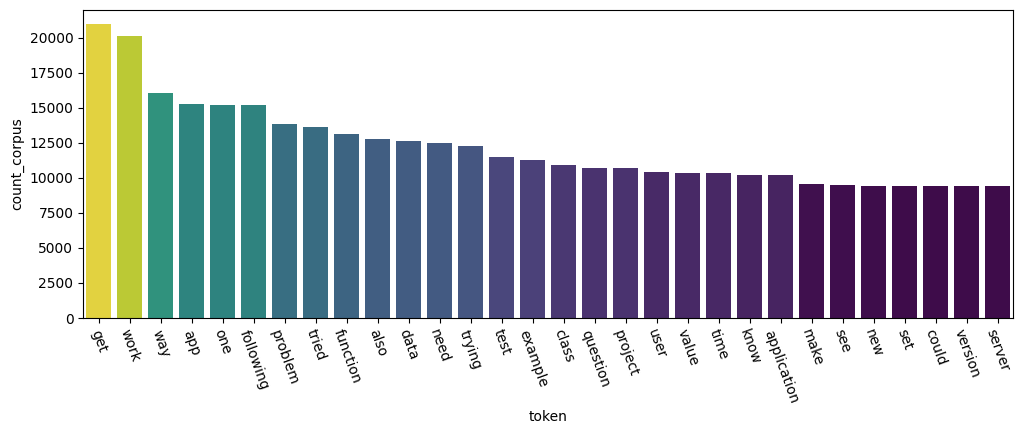

In [46]:
_ = stats_df.sort_values(by="count_corpus", ascending=False)[:30]
# plot it
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    _, x="token", y="count_corpus", hue="count_corpus", legend=False, palette="viridis"
)
ax.tick_params(axis="x", labelrotation=-70)

➡️ Pour une question de cohérence, **un nettoyage s'avère nécessaire après visualisation des mots les plus fréquents du corpus** : certains n'ont pas de sens (e.g. "'ve") ou font doublon malgré la lemmatisation (e.g. "tried" et "trying").

Les termes les plus fréquents sont donc analysés manuellement et dans la fonction de pré-traitement, une liste élargie des termes à exclure sera utilisée.

5 termes les moins fréquents

In [47]:
display(stats_df.sort_values(by="count_corpus", ascending=True)[:5])

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
0,'production,1,3.237851e-07,0,0.0,0,0.0,1,3.572893e-07
70756,migrationscaffolder,1,3.237851e-07,0,0.0,0,0.0,1,3.572893e-07
70755,migrations/versions,1,3.237851e-07,0,0.0,0,0.0,1,3.572893e-07
70754,migrations/update-database,1,3.237851e-07,0,0.0,0,0.0,1,3.572893e-07
70752,migrations/seeds,1,3.237851e-07,0,0.0,0,0.0,1,3.572893e-07


Combien de tags apparaissant au moins 5 fois dans le corpus ?

In [48]:
stats_df_tags.loc[stats_df_tags["count_tags"] > 4].shape[0]

4990

30 tags les plus fréquents

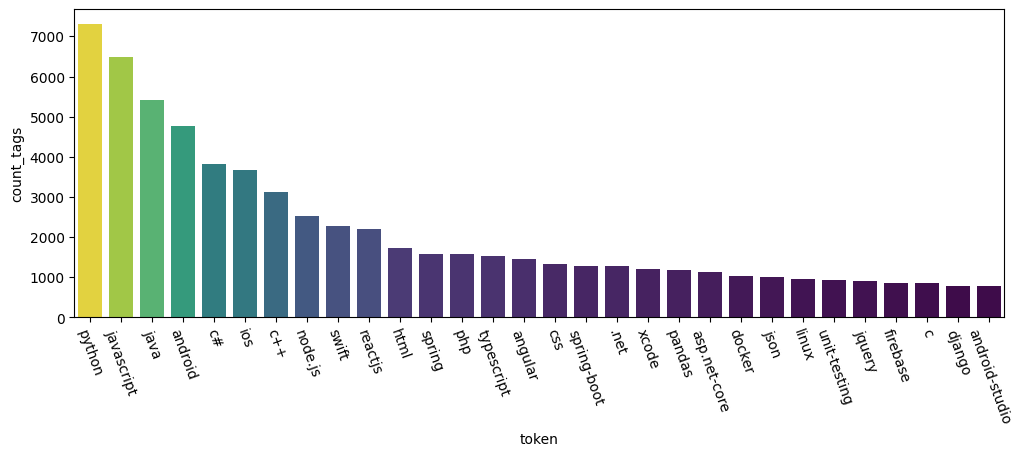

In [49]:
_ = stats_df.sort_values(by="count_tags", ascending=False)[:30]
# plot it
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    _, x="token", y="count_tags", hue="count_tags", legend=False, palette="viridis"
)
ax.tick_params(axis="x", labelrotation=-70)

In [50]:
tags_min4_df = stats_df_tags.loc[stats_df_tags["count_tags"] > 4]
tags_min4_df["token"]

2              .htaccess
3                   .net
7               .net-4.0
8               .net-4.5
10              .net-4.6
              ...       
16961                zsh
16963     zsh-completion
16965              zshrc
16968    zurb-foundation
16972              zxing
Name: token, Length: 4990, dtype: object

## <a id='toc4_3_'></a>[Nombre de tokens par type d'entrée](#toc0_)

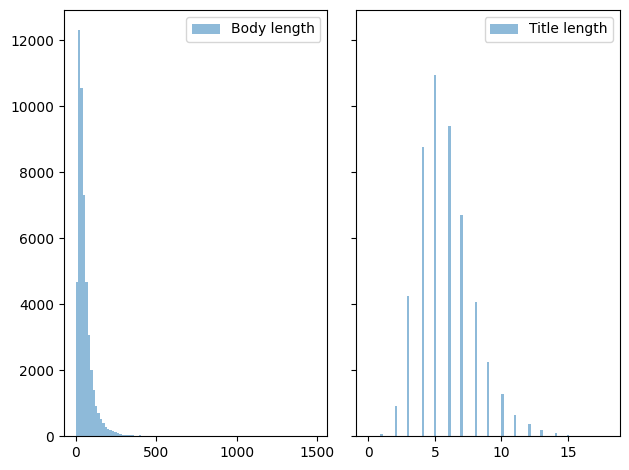

In [51]:
len_titles = []
len_bodies = []

df["title_bow"].apply(lambda x: len_titles.append(len(x.split(" "))))
df["body_bow"].apply(lambda x: len_bodies.append(len(x.split(" "))))

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    len_bodies,
    bins=np.linspace(0, max(len_bodies), 100),
    alpha=0.5,
    label="Body length",
)
axs[1].hist(
    len_titles,
    bins=np.linspace(0, max(len_titles), 100),
    alpha=0.5,
    label="Title length",
)
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

plt.show()

## <a id='toc4_4_'></a>[Nuages de mots](#toc0_)

### Pour les tags

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

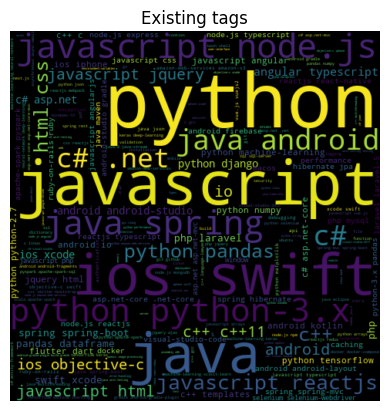

In [52]:
# assemble everything in a long string
long_string = " ".join(tags_list)

# wordcloud whole string
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# display
plt.title("Existing tags")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [53]:
dict(sorted(wordcloud.words_.items(), key=lambda item: item[1])[:-21:-1])

{'python': 1.0,
 'javascript': 0.8362507058159232,
 'ios swift': 0.7204968944099379,
 'java': 0.6725014116318464,
 'javascript node.js': 0.6245059288537549,
 'java spring': 0.6222473178994918,
 'python python-3.x': 0.5804630152456239,
 'java android': 0.5663466967814794,
 'c#': 0.5607001693958216,
 'c# .net': 0.49632975719932243,
 'javascript reactjs': 0.45736871823828346,
 'c++': 0.3749294184076793,
 'html css': 0.37323546019198195,
 'python pandas': 0.36645962732919257,
 'javascript jquery': 0.34839073969508755,
 'javascript html': 0.3455674760022586,
 'c++ c++11': 0.33258046301524563,
 'android': 0.3286278938452851,
 'io': 0.32298136645962733,
 'ios objective-c': 0.3167701863354037}

### Pour les titres

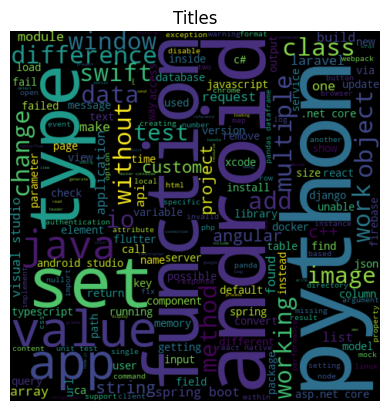

In [54]:
# assemble everything in a long string
long_string = " ".join(title_list)

# wordcloud whole string
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# display
plt.title("Titles")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [55]:
dict(sorted(wordcloud.words_.items(), key=lambda item: item[1])[:-21:-1])

{'python': 1.0,
 'android': 0.8213350785340314,
 'function': 0.5981675392670157,
 'type': 0.5497382198952879,
 'set': 0.5477748691099477,
 'value': 0.5235602094240838,
 'app': 0.518324607329843,
 'java': 0.5170157068062827,
 'difference': 0.5163612565445026,
 'class': 0.5078534031413613,
 'multiple': 0.506544502617801,
 'object': 0.4986910994764398,
 'without': 0.4757853403141361,
 'data': 0.46335078534031415,
 'add': 0.462696335078534,
 'io': 0.4620418848167539,
 'window': 0.44960732984293195,
 'work': 0.44960732984293195,
 'swift': 0.43848167539267013,
 'change': 0.4352094240837696}

### Pour les corps de texte et le corpus

Le noyau Jupyter ne peut pas assumer la gestion d'une telle chaîne de caractère, trop longue.

## <a id='toc4_5_'></a>[Répartition des langages de programmation](#toc0_)

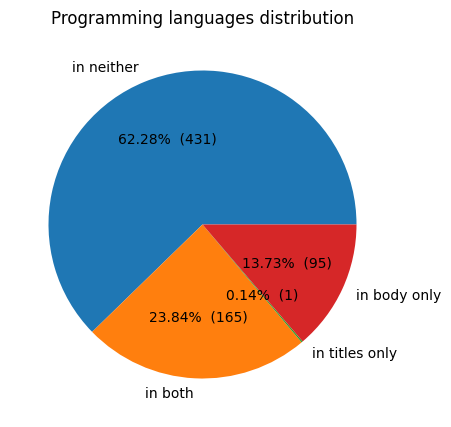

In [56]:
x = [
    len(prog_lang - title_vocab - body_vocab),
    len((prog_lang & title_vocab) & body_vocab),
    len((prog_lang & title_vocab) - body_vocab),
    len((prog_lang & body_vocab) - title_vocab),
]

plt.figure(figsize=(5, 5))
plt.title(f"Programming languages distribution")
plt.pie(
    x,
    labels=["in neither", "in both", "in titles only", "in body only"],
    autopct=make_autopct(x),
)

plt.show()

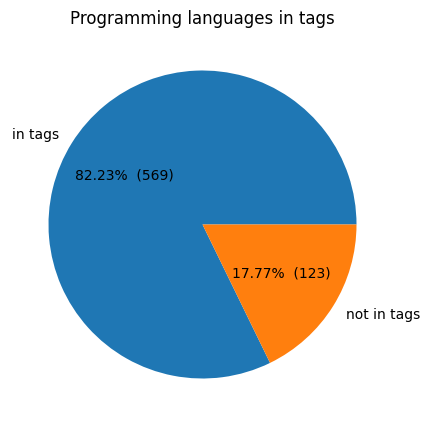

In [57]:
x = [
    len(prog_lang - tags),
    len(prog_lang & tags),
]

plt.figure(figsize=(5, 5))
plt.title(f"Programming languages in tags")
plt.pie(
    x,
    labels=["in tags", "not in tags"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc4_6_'></a>[Répartition des mots](#toc0_)

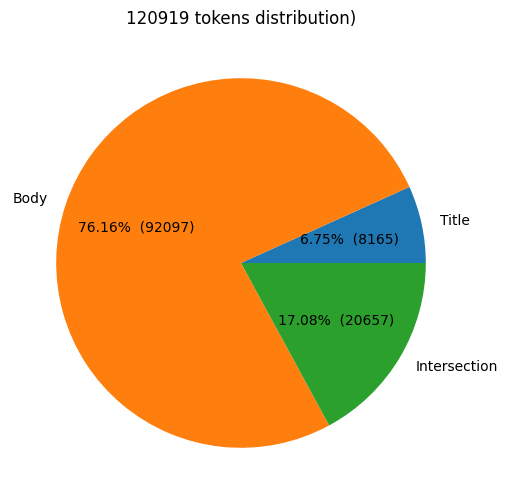

In [58]:
x = [
    len(title_vocab - body_vocab),
    len(body_vocab - title_vocab),
    len(title_vocab & body_vocab),
]

plt.figure(figsize=(6, 6))
plt.title(f"{len(corpus_vocab)} tokens distribution)")
plt.pie(
    x,
    labels=["Title", "Body", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc4_7_'></a>[Répartition et pertinence des tags](#toc0_)

In [59]:
missing_tags = tags - corpus_vocab

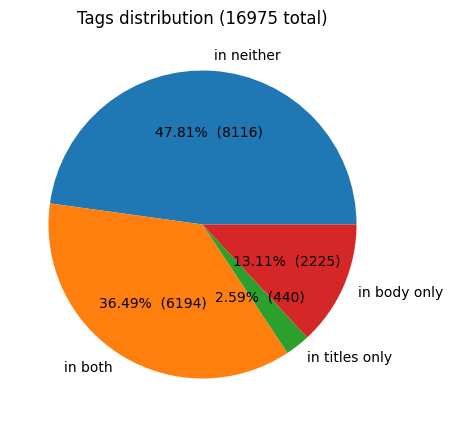

In [60]:
x = [
    len(missing_tags),
    len((tags & title_vocab) & body_vocab),
    len((tags & title_vocab) - body_vocab),
    len((tags & body_vocab) - title_vocab),
]

plt.figure(figsize=(5, 5))
plt.title(f"Tags distribution ({len(tags)} total)")
plt.pie(
    x,
    labels=["in neither", "in both", "in titles only", "in body only"],
    autopct=make_autopct(x),
)

plt.show()

Certains tags existants n'apparaissent donc ni dans les titres ni dans le corps de la question.

Plusieurs raisons à cela, notamment une suppression car ils font partie d'une ligne de code ou de liens HTML.

Voici un exemple :

In [61]:
_ = "uiresponder"

In [62]:
print(f"searching: {_}")
print(f"{_ in tags = }")
print(f"{_ in title_vocab = }")
print(f"{_ in body_vocab = }")

_df = df.loc[(df["Title"].str.contains(_)) | (df["Body"].str.contains(_))]

print(f'title:\n    {_df["Title"].values}')
print(f'body:\n    {_df["Body"].values}')

searching: uiresponder
_ in tags = True
_ in title_vocab = False
_ in body_vocab = True
title:
    ['Detect Single Modifier Key Change in UIKit for Mac (Catalyst)']
body:
    ['<p>I am porting an iOS app on MacOS using <em>UIKit for Mac</em> also known as <em>iPad Apps for Mac</em> or <em>Project Catalyst</em>.</p>\n\n<p>The app uses <a href="https://developer.apple.com/documentation/uikit/uiresponder/1621141-keycommands" rel="noreferrer"><code>keyCommands</code> from <code>UIKit</code></a> to detect a single modifier key press:</p>\n\n<pre><code>UIKeyCommand(input: "", modifierFlags: .shift, action: #selector(singleShift))\n</code></pre>\n\n<p>This code works perfectly on iPad with an external keyboard, I am getting the event fired with every single ⇧ press. However, this does not work on MacOS, although single non-modifier events and modifier + non-modifier combinations work.</p>\n\n<p>How do I achieve the desired behavior and get notified about single modifier key events?</p>\n\n<p>

## <a id='toc4_8_'></a>[Limite : pertience des tags utilisateurs](#toc0_)

Mais ce cas n'est pas exclusif : **parfois les internautes ont mis en tag des mots absents du titre et du corps de la question**.  
Cela **nuit naturellement aux modèles** dont l'apprentissage pourrait se faire sur cette donnée.

Il y a aussi un problème de **pertinence de certains tags**.  
Par exemple, le terme "get" est bien une méthode utilisée dans de nombreux cas mais aussi un élément de langage courant : il ressort donc couramment dans le corpus mais pas toujours de manière opportune.  

# Changement de stratégie et pré-traitement plus adapté

Comme cité plus haut, le nettoyage de pré-traitement va être renforcé pour les étapes de tests des modèles.

Mais en l'état, le jeu de données pose un problème plus important : 
- pour chaque question, les tags sont dans une liste, soit une dimension supplémentaire (5 tags par question)
    > Pour l'application des modèles, il y a **nécessité d'aplatir cette dimension** afin que **chaque tag soit représenté individuellement**.  
    > Un encodage one-hot serait trop gourmant en mémoire : l'aplatissement permet de conserver un minimum de colonnes, malgré un important nombre de lignes.
- cela va représenter un grand nombre de données, notamment lorsqu'il faudra les passer dans un modèle : il sera donc nécessaire d'**utiliser les tags les plus fréquents uniquement**, ce qui rendra également la **prédiction plus qualitative**

Explosion des questions par tag

In [148]:
df_pp = df.explode('Tags')

Sélection des tags les plus fréquents

In [149]:
# count tags and keep only those with at least 10 occurrences
vc = df_pp.Tags.value_counts()
tags_se_10 = vc[vc >= 10].index
print(f"{len(tags_se_10)} tags left")

2949 tags left


In [150]:
# filter dataframe on tags with at least 10 occurrences
df_pp = df_pp[df_pp.Tags.isin(tags_se_10)]

In [151]:
df_pp

,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount,title_bow,body_bow,doc_bow
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,ios,24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful build apple,itms-91053 missing api declaration privacy sud...
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,app-store,24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful build apple,itms-91053 missing api declaration privacy sud...
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,plist,24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful build apple,itms-91053 missing api declaration privacy sud...
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,python,28,2,2024-03-05 15:21:50,2699,builtin sorted slower list containing descendi...,sorted four similar list list consistently tak...,builtin sorted slower list containing descendi...
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,algorithm,28,2,2024-03-05 15:21:50,2699,builtin sorted slower list containing descendi...,sorted four similar list list consistently tak...,builtin sorted slower list containing descendi...
...,...,...,...,...,...,...,...,...,...,...
49998,CORS settings for IIS 7.5,<p>How can I convert the following code for us...,iis-7.5,12,2,2015-02-12 21:53:34,56289,cors settings iis,convert following web.config iis web.config pl...,cors settings iis convert following web.config...
49999,Extending prototypes in Javascript - good way?,<p>I want to validate that the approach I'm us...,javascript,11,7,2015-02-12 21:15:09,27124,extending prototype javascript good way,validate approach correct come extend prototyp...,extending prototype javascript good way valida...
49999,Extending prototypes in Javascript - good way?,<p>I want to validate that the approach I'm us...,oop,11,7,2015-02-12 21:15:09,27124,extending prototype javascript good way,validate approach correct come extend prototyp...,extending prototype javascript good way valida...
49999,Extending prototypes in Javascript - good way?,<p>I want to validate that the approach I'm us...,inheritance,11,7,2015-02-12 21:15:09,27124,extending prototype javascript good way,validate approach correct come extend prototyp...,extending prototype javascript good way valida...


Combien de questions ont été conservées ?

In [152]:
df_pp["doc_bow"].nunique()

49975

Ce pré-traitement permet de ne conserver que les tags les plus représentatifs et ne crée presque aucune perte au niveau des questions.

Il y a donc une **amélioration conséquente de la qualité des données**.